<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Бустинг-(LightGBM)" data-toc-modified-id="Бустинг-(LightGBM)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Бустинг (LightGBM)</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Общий-вывод-по-проекту" data-toc-modified-id="Общий-вывод-по-проекту-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод по проекту</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
import warnings
import math

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# загружаем данные
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# проверяем в хронологическом ли порядке стоят данные
print(data.index.is_monotonic)

True


In [7]:
# проверяем есть ли в данных пропуски
data.isna().sum()

num_orders    0
dtype: int64

In [8]:
# проверяем есть ли дублирующиеся временные отметки
data.index.duplicated().sum()

0

In [9]:
# ресемплирование по одному часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [11]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ данных

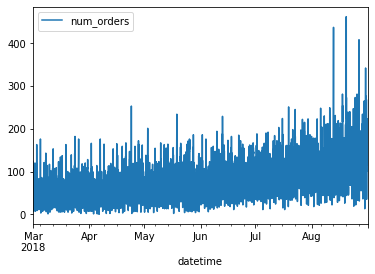

In [12]:
# посмотрим на график временного ряда
data.plot()
plt.show()

In [13]:
# посмотрим время последнего получения данных
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

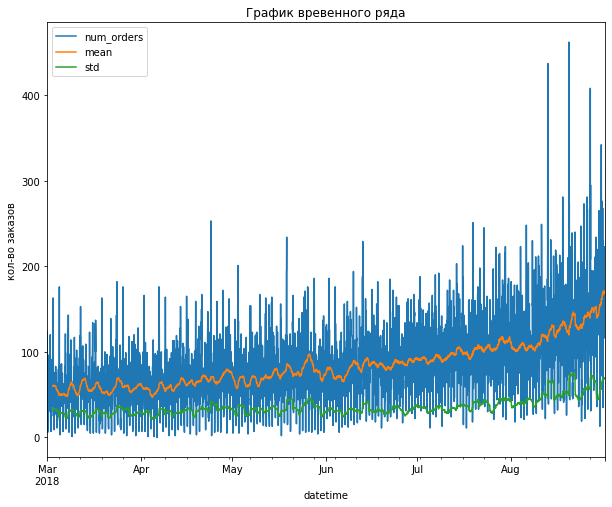

In [14]:
data_to_analaze = data.copy()
data_to_analaze['mean'] = data_to_analaze['num_orders'].rolling(48).mean()
data_to_analaze['std'] = data_to_analaze['num_orders'].rolling(48).std()
data_to_analaze.plot(figsize=(10, 8))
plt.ylabel('кол-во заказов')
plt.title('График вревенного ряда')
plt.show()

Таким образом, мы имеем данные о заказах такси в аэропортах **с марта по август, включительно, то есть в весенне-летний период**.

И среднее, и стандартное отклонение растут со временем, следовательно **ряд нестационарный**.

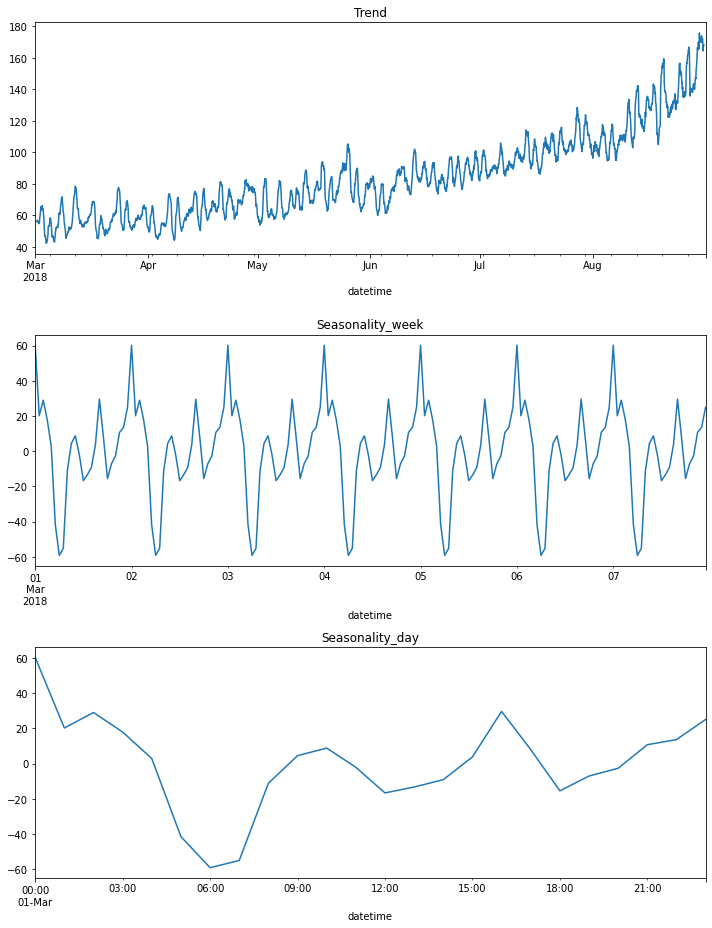

In [15]:
# разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 13))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality_week')
plt.subplot(313)
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())
plt.title('Seasonality_day')
plt.tight_layout()

На графике тренда видно, что **количество заказов в летний период больше, чем в весенний**. В целом, по этому графику можно сказать, что **количество заказов только продолжает расти с приближением к осени**. Это может быть связано с тем, что лето и начало осени – это период отпусков.

На графике сезонности в течение недели видна определенная закономерность, проявляющаяся каждый день.

На графике сезонности в течение дня видно, что **чаще всего такси заказывают в первые часы ночи (00:00 – 03:00), что вполне ожидаемо, так как рейсы с таким временем очень популярны**. Также наблюдается увеличение количества заказов утром с 09:00 до 10:00 и в 16:00. **Меньше всего заказов с 05:00 до 07:00 утра**.

## Создание признаков

In [16]:
# функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
# создаем признаки
make_features(data, 168, 168)

In [18]:
data.head(10)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# разделим выборки на train и test
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [20]:
# проверим размеры выборок
display(features_train.shape, target_train.shape)
display(features_test.shape, target_test.shape)

(3806, 171)

(3806,)

(442, 171)

(442,)

In [21]:
features_train.head()

,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,54.226190
2018-03-08 01:00:00,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.339286
2018-03-08 02:00:00,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.297619
2018-03-08 03:00:00,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,54.261905
2018-03-08 04:00:00,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.273810


## Обучение моделей

In [22]:
# заготовка для сводной таблицы по всем моделям
rmse_score_diff_methods = pd.DataFrame()

In [23]:
TSCV = TimeSeriesSplit(n_splits=5)

### Линейная регрессия

In [24]:
%%time

model = Ridge(random_state=42)

params = {'alpha': np.arange(0.00, 0.25, 0.01)}

grid = GridSearchCV(model,  
                    param_grid=params, 
                    cv=TSCV, 
                    scoring='neg_root_mean_squared_error',  
                    n_jobs=-1, 
                    verbose=1)

grid.fit(features_train, target_train)

best_model_ridge = grid.best_estimator_
best_parametrs_ridge = grid.best_params_
best_result_ridge = grid.best_score_ * -1

Fitting 5 folds for each of 25 candidates, totalling 125 fits
CPU times: user 195 ms, sys: 74.3 ms, total: 270 ms
Wall time: 4.41 s


In [25]:
print(f'Лучший результат RMSE модели: {best_result_ridge}') # лучший результат RMSE модели
print(f'Лучшие параметры модели: {best_parametrs_ridge}') # лучшие параметры модели

Лучший результат RMSE модели: 22.54464706962755
Лучшие параметры модели: {'alpha': 0.24}


In [26]:
rmse_score_diff_methods.loc['Ridge', 'RMSE'] = best_result_ridge

### Дерево решений

In [27]:
%%time

model = DecisionTreeRegressor(random_state=42)

params = {'max_depth': range(2, 15)}

grid = GridSearchCV(model, 
                    param_grid=params,
                    cv=TSCV,  
                    scoring='neg_root_mean_squared_error',  
                    n_jobs=-1, 
                    verbose=1)

grid.fit(features_train, target_train)

best_model_tree = grid.best_estimator_
best_parametrs_tree = grid.best_params_
best_result_tree = grid.best_score_ * -1

Fitting 5 folds for each of 13 candidates, totalling 65 fits
CPU times: user 369 ms, sys: 49.4 ms, total: 419 ms
Wall time: 13.9 s


In [28]:
print(f'Лучший результат RMSE модели: {best_result_tree}') # лучший результат RMSE модели
print(f'Лучшие параметры модели: {best_parametrs_tree}') # лучшие параметры модели

Лучший результат RMSE модели: 26.69035614404435
Лучшие параметры модели: {'max_depth': 4}


In [29]:
rmse_score_diff_methods.loc['DecisionTreeRegressor', 'RMSE'] = best_result_tree

### Случайный лес

In [30]:
%%time

model = RandomForestRegressor(random_state=42)

params = {'n_estimators': range(50, 251, 50),
          'max_depth': range(2, 15),
          'min_samples_split': (2, 3, 4),
          'min_samples_leaf': (1, 2, 3, 4)}

grid = RandomizedSearchCV(model, 
                          param_distributions=params,
                          n_iter = 15,
                          scoring='neg_root_mean_squared_error',  
                          cv=TSCV, 
                          n_jobs=-1,  
                          random_state=42, 
                          verbose=1)

grid.fit(features_train, target_train)

best_model_forest = grid.best_estimator_
best_parametrs_forest = grid.best_params_
best_result_forest = grid.best_score_ * -1

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: user 26.1 s, sys: 475 ms, total: 26.6 s
Wall time: 14min 32s


In [31]:
print(f'Лучший результат RMSE модели: {best_result_forest}') # лучший результат RMSE модели
print(f'Лучшие параметры модели: {best_parametrs_forest}') # лучшие параметры модели

Лучший результат RMSE модели: 22.848722771175336
Лучшие параметры модели: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 14}


In [32]:
rmse_score_diff_methods.loc['RandomForestRegressor', 'RMSE'] = best_result_forest

### Бустинг (LightGBM)

In [33]:
%%time

params = {'learning_rate': [0.5, 0.1],
          'max_depth': range(1, 8),
          'n_estimators': range(50, 351, 50)}

model = lgb.LGBMRegressor(random_state=42)
grid = RandomizedSearchCV(model, 
                          param_distributions=params, 
                          n_iter = 25,
                          scoring='neg_root_mean_squared_error', 
                          cv=TSCV,
                          n_jobs=-1, 
                          random_state=42,
                          verbose=1)

grid.fit(features_train, target_train)

best_model_lgb = grid.best_estimator_
best_parametrs_lgb = grid.best_params_
best_result_lgb = grid.best_score_ * -1

Fitting 5 folds for each of 25 candidates, totalling 125 fits
CPU times: user 1.66 s, sys: 84.1 ms, total: 1.74 s
Wall time: 1min 38s


In [34]:
print(f'Лучший результат RMSE модели: {best_result_lgb}') # лучший результат RMSE модели
print(f'Лучшие параметры модели: {best_parametrs_lgb}') # лучшие параметры модели

Лучший результат RMSE модели: 22.68949565215603
Лучшие параметры модели: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


In [35]:
rmse_score_diff_methods.loc['LightGBM', 'RMSE'] = best_result_lgb

### Сравнение моделей

In [36]:
rmse_score_diff_methods

,RMSE
Ridge,22.544647
DecisionTreeRegressor,26.690356
RandomForestRegressor,22.848723
LightGBM,22.689496


Из таблицы видно, что **лучше всего с задачей справилась линейная модель со следующими гиперпараметрами: alpha – 0.24**. По результатам кросс-валидации ее RMSE равно 25.5.

Кроме того данная модель учится значительно быстрее, чем случайный лес или бустинг.

## Тестирование лучшей модели

In [38]:
%time

predicted_test = best_model_ridge.predict(features_test)

print(f'RMSE на тестовой выборке: {round(math.sqrt(mean_squared_error(target_test, predicted_test)), 2)}')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
RMSE на тестовой выборке: 34.53


На тестовой выборке выбранная модель показала хороший результат – **RMSE равно 34.5**.

## Общий вывод по проекту

**В проекте велась работа с историческими данными о заказах такси в аэропортах.** Данные представляют собой временной ряд, в котором содержится информация о том, сколько машин заказывают каждые 10 минут.

**Целевой признак:** `num_orders` — количество заказов.

**Задача состояла в построение модели, которая может спрогнозировать количество заказов такси на следующий час (задача регрессии).**

**Перед началом анализа данные были подготовлены:**
- проведена проверка на наличие пропусков и дубликатов; 
- установлено, что данные расположены в хронологическом порядке;
- созданы признаки для обучения (календарные признаки, лаги и скользящее среднее);
- подготовлены выборки для обучения моделей.

Кроме того был проведен анализ данных. Было установлено, что мы имеем дело с **нестационарным временным рядом**, в котором предствлены данные о заказах такси в аэропортах **с марта по август, включительно, то есть в весенне-летний период**.

**Мы попробовали обучить несколько моделей: гребневую регрессию (ridge), дерево решений, случайный лес, а так же модель градиентного бустинга LightGBM.** Каждая модель обучалась с применением кросс-валидации и перебором нескольких гиперпараметров.

**По результатам экспериментов лучший результат показала линейная модель со следующими гиперпараметрами: alpha – 0.24. По результатам кросс-валидации ее RMSE равно 25.5.**

Кроме того данная модель учится значительно быстрее, чем случайный лес или бустинг.

Затем модель с данными параметрами была проверена на тестовой выборке. Она показала хороший результат – **RMSE равно 34.5**. Данное значение соответствует условию, согласно которому значение данной метрики не должно превышать 48.